Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


In [194]:
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt

In [195]:
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)
users = pd.DataFrame(data)
users.head()
print(users.columns)
print(users.describe())
print(users.info())

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')
           avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips

Looking at the data I've just pulled into the dataframe, I notice a couple things right away. First, there are missing values in relatively important seeming columns. Average rating of driver seems like it is probably a fairly predictive feature in identifying active users. Could be that these users never actually rated a driver and are therefore not active, but we'll take a closer look a little later. Second thing I notice is that several of the columns will need to be reformated for analysis, and a target column will have to be made. I'll go through these steps below.

In [197]:
#Time data to datetime - need for timedeltas 
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'])
users['signup_date'] = pd.to_datetime(users['signup_date'])

#Getting active (therefore retained) users. Last day and timedelta first
last_day = max(users['last_trip_date'])
thirty_days = [last_day - datetime.timedelta(days=x) for x in range(0,30)]

#Boolean mask for active users and filling retained with 0 or 1
active = users['last_trip_date'].isin(thirty_days)
users['retained'] = 0
users.loc[active, 'retained'] = 1


Given the features we have here, the avg ratings seem as if they'll be very important features. Imputing the values with a mean or median of all the other ratings does not make sense here as we'll lose potentially valuable information contained in the rest of the values. Given the datset is fairly substantial, dropping 18% of it to save the sanctity of the values contained in these important columns seems like the right move. This will leave us with 41,744 users.

In [198]:
#look at the rows missing the average driving rating and average user rating
display(users[users['avg_rating_of_driver'].isnull()].head(10))
display(users[users['avg_rating_by_driver'].isnull()].head(10))

#Fill missing phone with mode (iPhones) and drop all remaining columns with NaN values
users['phone'].fillna('iPhone',inplace=True)
users = users.dropna(axis=0)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
6,3.95,4.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,0
9,2.37,5.0,NaN,1.0,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,0
12,20.29,5.0,NaN,1.0,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0,0
14,26.01,5.0,NaN,1.0,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0,0
15,13.20,5.0,NaN,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0,0
20,2.53,3.0,NaN,1.0,Winterfell,2014-03-16,Android,2014-01-31,0.0,1,False,50.0,0
21,3.31,5.0,NaN,1.0,Astapor,2014-04-29,iPhone,2014-01-09,0.0,1,False,100.0,0
22,11.47,5.0,NaN,1.0,Winterfell,2014-05-02,iPhone,2014-01-24,0.0,0,False,100.0,0
25,14.48,5.0,NaN,1.0,Winterfell,2014-01-03,iPhone,2014-01-02,0.0,1,True,100.0,0
28,5.97,5.0,NaN,1.5,Winterfell,2014-06-08,iPhone,2014-01-19,100.0,0,False,0.0,1


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
90,6.28,NaN,5.0,1.00,Winterfell,2014-02-09,iPhone,2014-01-10,0.0,1,False,0.0,0
274,6.00,NaN,2.0,4.00,Astapor,2014-02-09,iPhone,2014-01-25,100.0,1,False,0.0,0
277,1.82,NaN,NaN,1.00,Winterfell,2014-01-26,iPhone,2014-01-25,0.0,1,False,0.0,0
536,1.41,NaN,5.0,1.00,Winterfell,2014-02-08,Android,2014-01-18,0.0,1,False,100.0,0
857,0.42,NaN,4.0,1.00,Winterfell,2014-03-16,iPhone,2014-01-11,0.0,0,False,0.0,0
1021,2.33,NaN,NaN,1.75,King's Landing,2014-06-13,iPhone,2014-01-23,100.0,0,True,100.0,1
1073,9.21,NaN,5.0,1.00,King's Landing,2014-04-27,Android,2014-01-19,0.0,0,False,0.0,0
1164,2.57,NaN,2.0,1.00,Winterfell,2014-01-25,Android,2014-01-24,0.0,1,True,100.0,0
1181,24.91,NaN,3.0,1.00,Winterfell,2014-01-25,Android,2014-01-25,0.0,1,False,0.0,0
1205,8.94,NaN,NaN,1.00,Winterfell,2014-02-22,Android,2014-01-18,0.0,0,False,100.0,0


The next step is going to be turning all the categorical variables into numerical variables. This could be done with get dummies but it is fairly simple to just map a dictionary as there are at most 3 classes. I will also drop uncessary columns,  last trip date, signup date and surge_pct which is highly coorelated with avg_surge. Also going to refactor weekday_pct to be between 0-1 as all the others variables are on that scale.

In [199]:
print('Correlation between average surge and surge pct:', users['avg_surge'].corr(users['surge_pct']))

Correlation between average surge and surge pct: 0.7957584583233167


In [200]:
# Dictionaries for mapping to numerical
cities = {'Winterfell':0,'Astapor':1,"King's Landing":2}
phones = {'iPhone':0, 'Android':1}
ultimate_black = {False:0,True:1}

# Mapping
users['city'] = users['city'].map(cities)
users['phone'] = users['phone'].map(phones)
users['ultimate_black_user'] = users['ultimate_black_user'].map(ultimate_black)

# Refactor and drop un-needed columns
users['weekday_pct'] = users['weekday_pct']/100
users = users.drop(['last_trip_date','signup_date','surge_pct'],axis = 1)
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,2,0,4,1,0.462,1
1,8.26,5.0,5.0,1.00,1,1,0,0,0.500,0
2,0.77,5.0,4.3,1.00,1,0,3,0,1.000,0
3,2.36,4.9,4.6,1.14,2,0,9,1,0.800,1
4,3.13,4.9,4.4,1.19,0,1,14,0,0.824,0


Now let's look at some of the features in relation to our target

In [87]:
columns = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','trips_in_first_30_days','weekday_pct','retained']
retain_grouped = users[columns].groupby('retained').mean()
display(retain_grouped)
retained_pct = round(len(users[users['retained'] == 1])/len(users),4)
print('Overall Percentage of Users Retained: {}'.format(retained_pct))

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,trips_in_first_30_days,weekday_pct
retained,,,,,,
0,5.833257,4.788216,4.607471,1.074385,1.937480,0.605497
1,4.915066,4.759350,4.593323,1.072667,3.619201,0.624332


Overall Percentage of Users Retained: 0.4007


Above, retained (or active) is 1, non active (or retained) is 0. We do see some differences in the mean values of both groups, although we can't tell whether these are statistically significant differences without doing some inferential stats. Looking more closely at distance and trips in first 30 as these look to be most predictive. 

In [99]:
avg_distance = users[['avg_dist','retained']].groupby('retained').describe()
trips = users[['trips_in_first_30_days','retained']].groupby('retained').describe()
display(avg_distance,trips)

avg_dist                                                  
            count      mean       std  min   25%   50%   75%    max
retained                                                           
0         25016.0  5.833257  5.700207  0.0  2.31  3.89  7.24  79.69
1         16728.0  4.915066  4.133534  0.0  2.57  3.68  5.66  79.34

trips_in_first_30_days                                               
                          count      mean       std  min  25%  50%  75%    max
retained                                                                      
0                       25016.0  1.937480  2.920399  0.0  0.0  1.0  2.0   73.0
1                       16728.0  3.619201  5.166090  0.0  0.0  2.0  5.0  125.0

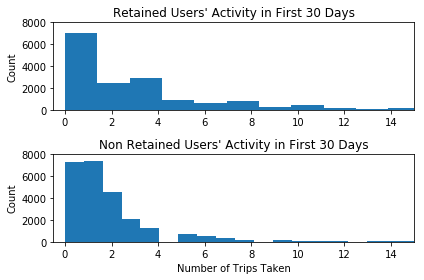

In [125]:
active = users['trips_in_first_30_days'].loc[users['retained'] == 1]
not_active = users['trips_in_first_30_days'].loc[users['retained'] == 0]

plt.subplot(2,1,1)
plt.hist(active,bins=90)
plt.title("Retained Users' Activity in First 30 Days")
plt.ylabel('Users')
plt.xlim(-.5,15)
plt.ylim(0,8000)

plt.subplot(2,1,2)
plt.hist(not_active,bins=90)
plt.title("Non Retained Users' Activity in First 30 Days")
plt.ylabel('Users')
plt.xlabel('Number of Trips Taken')
plt.xlim(-.5,15)
plt.ylim(0,8000)
plt.tight_layout()
plt.show()

The figures above seem to suggest that users who don't continue using Ultimate drop off their usage after about 2 times using the app. Let's move on to model building! I'm going to take a look at several classification algorithms and see which one performs the best. Naive bayes, logistic regression, SVM, k-nearest neighbors and a random forest

In [143]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [152]:
# Features target and train test split

X = users.drop('retained',axis=1)
y = users['retained']
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [135]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC'], columns=['Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Random Forest', 'Naive Bayes'])
metrics

,Logistic Regression,K Nearest Neighbors,Support Vector Machine,Random Forest,Naive Bayes
accuracy,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN
AUC,NaN,NaN,NaN,NaN,NaN


In [168]:
# Instantiate models

logreg = LogisticRegression(solver='liblinear')
neighbors = KNeighborsClassifier()
svm = SVC()
forest = RandomForestClassifier()
nb = GaussianNB()
model_names = ['Logistic Regression','K-Nearest Neighbors','SVM','RandomForestClassifier','GaussianNB']
models = [logreg,neighbors,svm,forest,nb]

# Define hyperparameter space

logreg_grid = None #{'C': np.logspace(-5, 8, 15),'penalty': ['l1', 'l2']}

neighbors_grid = None #{'n_neighbors': np.arange(1,20)}

svm_grid = None #{'C': [0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01]}

forest_grid = None #{'n_estimators': [50, 100],'max_depth': [3, 10, 20],
               #'min_samples_leaf': np.arange(1, 9),
               #'min_samples_split': np.arange(2, 9),
               #'max_features': np.arange(1, 9)}

nb_grid = None
parameters = [logreg_grid,neighbors_grid,svm_grid,forest_grid,nb_grid]
names_dict_params = dict(zip(model_names,parameters))
names_dict_models = dict(zip(model_names,models))

In [174]:
def train_and_score_model(models_dict,params_dict,X_train,y_train,X_test,y_test):
    for model in model_names:
        if params_dict[model] == None:
            models_dict[model].fit(X_train,y_train)
            predictions = models_dict[model].predict(X_test)
            print('The classification report for ' + model + ' is:') 
            print(metrics.classification_report(predictions,y_test))
            print(metrics.confusion_matrix(predictions,y_test))
        else:
            cv = GridSearchCV(models_dict[model],params_dict[model],scoring = 'accuracy',cv =5)
            cv.fit(X_train,y_train)
            predictions = cv.predict(X_test)
            print('The classification report for ' + model + ' is:') 
            print(metrics.classification_report(predictions,y_test))

In [175]:
train_and_score_model(names_dict_models,names_dict_params,X_train,y_train,X_test,y_test)

The classification report for Logistic Regression is:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      7459
           1       0.46      0.65      0.54      2977

   micro avg       0.69      0.69      0.69     10436
   macro avg       0.65      0.68      0.65     10436
weighted avg       0.73      0.69      0.70     10436

[[5228 2231]
 [1038 1939]]
The classification report for K-Nearest Neighbors is:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      6353
           1       0.63      0.64      0.63      4083

   micro avg       0.71      0.71      0.71     10436
   macro avg       0.70      0.70      0.70     10436
weighted avg       0.71      0.71      0.71     10436

[[4800 1553]
 [1466 2617]]


C:\Users\nhcam\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The classification report for SVM is:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      6998
           1       0.58      0.71      0.64      3438

   micro avg       0.74      0.74      0.74     10436
   macro avg       0.71      0.73      0.72     10436
weighted avg       0.75      0.74      0.74     10436

[[5259 1739]
 [1007 2431]]
The classification report for RandomForestClassifier is:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      6733
           1       0.63      0.70      0.66      3703

   micro avg       0.75      0.75      0.75     10436
   macro avg       0.73      0.74      0.73     10436
weighted avg       0.75      0.75      0.75     10436

[[5173 1560]
 [1093 2610]]
The classification report for GaussianNB is:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6058
           1       0.67      0.64      0.65

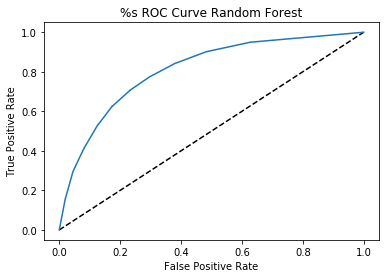

0.8094142305051586


In [184]:
y_prob = forest.predict_proba(X_test)
fpr, tpr, thresholds  = metrics.roc_curve(y_test, y_prob[:,1])
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve Random Forest')
plt.show()
print(metrics.roc_auc_score(y_test,y_prob[:,1]))

The best performing model looks to be the random forest with an f1 score of 0.66 for predicting the class of interest (1's or was retained). The ROC curve for the random forest model is reproduced above. Bearing in mind all of these models are untuned (due to computing constraints, I specified a hyperparamter space but did not search it) and performance may still be increased, this model is a valid option for predicting retainment of customers. 

The most useful measure for adjudging this is the AUC, printed above under the ROC curve. This means that the random forest model has 81% probability of correctly distinguising between the positive and negative classes. This is pretty good, a significant improvement on a dummy model that predicts randomly (illustrated by the dotted line on the ROC curve). Of course one caveat to note is that the tradeoff between recall and specificity may be adjusted for business goals and metrics. My recommendation would be to set a probability threshold wherein specificity is around 0.35 - 0.4 and recall hovers around 0.8 - 0.85. This would mean that 80% of customers likely to be retained are indentified.

In order to assess actionable strategies other than targeting customers who are likely to drop, we must look at the feature importance given by the random forest model. This is pushed to a dataframe below for ease of viewing. What we see is that average distance, weekday percentage and average rating by driver have the 3 highest feature importances. Their correlations with the target variable are also printed below. While these correlations are not particularly large, they seem to suggest that users who take short rides during the week are most likely to be retained. This suggests a strong short distance commuting group. Perhaps offering commuter benefits or reduced rates for longer trips during rush hour would be useful programs. 

In [185]:
pd.DataFrame(forest.feature_importances_,index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
avg_dist,0.286175
weekday_pct,0.150965
avg_rating_by_driver,0.136416
avg_surge,0.094575
city,0.086652
trips_in_first_30_days,0.083232
avg_rating_of_driver,0.082246
phone,0.043823
ultimate_black_user,0.035915


In [192]:
print('Correlation between average distance and retainment:', users['avg_dist'].corr(users['retained']))
print('Correlation between percentage of weekday rides and retainment:', users['weekday_pct'].corr(users['retained']))
print('Correlation between average rating (by driver) and retainment:', users['avg_rating_by_driver'].corr(users['retained']))

Correlation between average distance and retainment: -0.08737432969108992
Correlation between percentage of weekday rides and retainment: 0.026523703698673084
Correlation between average rating (by driver) and retainment: -0.035004908056296614
